**Задача 3. Решить однородное уравнение теплопроводности на отрезке [0,1]**

In [7]:
from IPython.core.display import display, HTML

display(HTML("<style>.container {width: 100%; !important; }</style>"))

In [8]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from matplotlib import cm

from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [9]:
pd.set_option('display.max_columns', 30)

pd.set_option('display.precision',3)

In [10]:
# Размерность сетки по длинне отрезка:
n_grid = np.array([10, 100])

# Размерность сетки по времени:
Ts = np.array([5, 10, 15])

# Разбиение по времени:
tau = 0.05

# Граничное условие при x=0:
def mu1(t):
    res = np.zeros(shape=t.shape,
                   dtype=np.float32)
    return res

# Граничное условие при x=1:
def mu2(t):
    res = np.zeros(shape=t.shape,
                   dtype=np.float32)
    return res

# Параметр разностной схемы сигма:
sigmas = np.array([0.5])

# Функция k(x):
def k(x):
    res = np.ones(shape=x.shape,
                  dtype=np.float32)
    return res

# Начальное условие: fi(x):
def fi(x_):
    res = 3 * np.sin(np.pi * x_)
    return res

In [11]:
def analitic_result(x_, t_):
    e = np.exp(-9.8696 * t_)
    e = np.expand_dims(e, axis = 0)
    e = e.reshape(-1, 1)
    
    res = fi(x_) * e
    return res

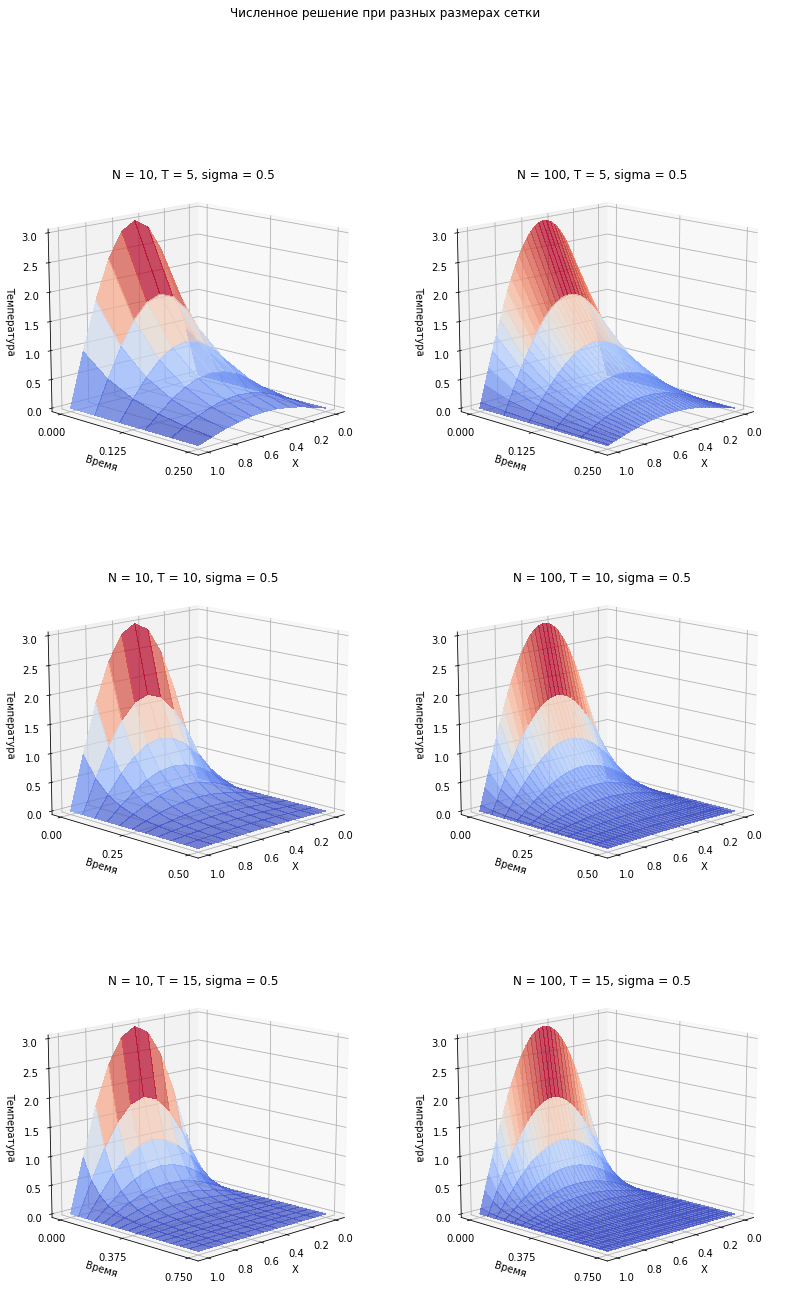

In [13]:
fig, axes = plt.subplots(3,
                         2,
                         subplot_kw=dict(projection='3d'))
fig.set_figheight(21)
fig.set_figwidth(14)

fig.suptitle("Численное решение при разных размерах сетки")

result = dict()

for i, T in enumerate(Ts):
    for j, n in enumerate(n_grid):
        for l, sigma in enumerate(sigmas):
            axes[i, j + l*2].set_title('N = {0}, T = {1}, sigma = {2}'.format(n,
                                                                              T,
                                                                              sigma))
            axes[i, j + l*2].set_xlabel('X')
            axes[i, j + l*2].set_ylabel('Время')
            axes[i, j + l*2].set_zlabel('Температура')
            axes[i, j + l*2].grid()

            x = np.linspace(0, 1, n+1)
            time = np.linspace(0, tau * T, T+1)
            h = 1/n
            
            axes[i, j + l*2].set_yticks(np.linspace(0, tau * T, 3))
                
            coef = tau * sigma / (h ** 2)
            A = coef * k(x + h/2)
            B = coef * k(x - h/2)
            C = A + B + 1

            alpha = np.zeros((1, n),
                             dtype=np.float32)
            for ind in range(1, n):
                alpha[0, ind] = A[ind-1]/(C[ind-1] -
                                         B[ind-1] * alpha[0, ind-1])
            
            beta = np.zeros((T, n),
                            dtype=np.float32)
            beta[:, 0] = mu1(time)[1:]
            
            temp = np.zeros((T+1, n+1),
                            dtype=np.float32)
            temp[0, :] = fi(x)
            temp[:, 0] = mu1(time)
            temp[:, n] = mu2(time)

            diff = (C[:-1] - B[:-1] * alpha[0, :])
            for ind in range(1, T+1):
                delta_plus = temp[ind-1, 2:n+1] - temp[ind-1, 1:n]
                delta_minus = temp[ind-1, 1:n] - temp[ind-1, 0:n-1]
                
                f = (temp[ind-1, 1:n] +
                     (1 - sigma) * tau * (1/h**2) *
                     (k(x + h/2)[1:n] * delta_plus -
                      k(x - h/2)[1:n] * delta_minus))
                
                for idx in range(1, n):
                    beta[ind-1, idx] = ((f[idx-1] +
                                        B[idx-1] * beta[ind-1, idx-1])/
                                        diff[idx-1])

                temp[ind, n-1] = (alpha[0, n-1] * mu2(time)[ind] +
                                  beta[ind-1, n-1])
                
                for idx in range(1, n-1):
                    temp[ind, n-1-idx] = (alpha[0, n-1-idx] * temp[ind, n-idx] +
                                          beta[ind-1, n-1-idx])

            x_mesh, time_mesh = np.meshgrid(x, time)
            
            axes[i, j + l*2].plot_surface(x_mesh,
                                          time_mesh,
                                          temp,
                                          cmap=cm.coolwarm,
                                          linewidth=1,
                                          antialiased=False,
                                          shade=True,
                                          alpha = 0.7)
            axes[i, j + l*2].view_init(15, 45)
            
            df_results = pd.DataFrame(data=temp,
                                      index=time,
                                      columns=np.around(x, decimals=2))
            
            temp_an = analitic_result(x, time)
            
            df_results['delta_temp'] = np.power((temp - temp_an), 2).sum(axis=1)
            
            result.update({(n, T, sigma): df_results})

plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()

In [14]:
# Результаты и погрешность численных вычислений:

for r in result:
    print('N = {0}; T = {1}; Sigma = {2}\ntime:\tx:\n{3}\n...'.format(r[0],
                                                                      r[1],
                                                                      r[2],
                                                                      result[r].iloc[:, :11].head()))
    delta = result[r].delta_temp.mean()
    print('Погрешность = {:.6f}\n'.format(delta))

N = 10; T = 5; Sigma = 0.5
time:	x:
      0.0    0.1    0.2    0.3    0.4    0.5    0.6    0.7    0.8    0.9  1.0
0.00  0.0  0.927  1.763  2.427  2.853  3.000  2.853  2.427  1.763  0.927  0.0
0.05  0.0  0.563  1.070  1.473  1.731  1.820  1.731  1.473  1.070  0.563  0.0
0.10  0.0  0.341  0.649  0.894  1.051  1.105  1.051  0.894  0.649  0.341  0.0
0.15  0.0  0.207  0.394  0.542  0.637  0.670  0.637  0.542  0.394  0.207  0.0
0.20  0.0  0.126  0.239  0.329  0.387  0.407  0.387  0.329  0.239  0.126  0.0
...
Погрешность = 0.000516

N = 100; T = 5; Sigma = 0.5
time:	x:
      0.00   0.01   0.02   0.03   0.04   0.05   0.06   0.07   0.08   0.09  \
0.00   0.0  0.094  0.188  0.282  0.376  0.469  0.562  0.654  0.746  0.837   
0.05   0.0  0.057  0.114  0.171  0.227  0.284  0.340  0.395  0.451  0.506   
0.10   0.0  0.034  0.069  0.103  0.137  0.171  0.205  0.239  0.272  0.306   
0.15   0.0  0.021  0.042  0.062  0.083  0.104  0.124  0.144  0.165  0.185   
0.20   0.0  0.013  0.025  0.038  0.050  0.063 